# 💳 Transaction Anomaly Detection using Isolation Forest

This notebook trains a machine learning model to detect anomalous transactions from a given dataset. We will use **Isolation Forest**, an unsupervised algorithm that excels at identifying outliers. It works by learning to isolate observations and flagging those that require fewer partitions to be separated from the rest.

This approach is powerful because it does not require pre-labeled data for training, even though we will use the labels in our dataset to evaluate its performance.

### The Pathway 🚀
1.  **Data Loading & Exploration**: Load the dataset and understand its structure.
2.  **Feature Engineering**: Create new, meaningful features from the raw data that will help the model learn.
3.  **Data Preprocessing**: Prepare the data for training by splitting and scaling it.
4.  **Model Training**: Train an **Isolation Forest** model.
5.  **Model Evaluation**: Assess the model's performance using appropriate metrics.
6.  **Model Saving**: Serialize the trained model and necessary components for future use.
7.  **Real-Time Integration Plan**: Outline the steps to deploy this model in a live environment.

--- 
## Step 1: Setup and Data Loading

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest  # <-- Changed from LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import joblib # For saving the model

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

In [26]:
# Load the dataset
df = pd.read_csv('transaction_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (500000, 7)

First 5 rows:


,userId,transactionId,amount,txn_date,txn_latitude,txn_longitude,is_anomaly
0,user_0,b83e5523-3ce2-4e79-9852-88c2fb1ac1ff,1178.35,2024-12-07 19:46:23.932057,12.749427,77.177923,False
1,user_2202,a8749a3a-eb01-41c6-b9cd-015415537f77,1655.27,2024-10-24 15:20:44.617594,13.112262,77.208663,False
2,user_1946,735fad2a-4403-4c89-b66b-62e9af4ff5de,1347.57,2025-01-17 03:01:20.347330,14.143344,76.924813,False
3,user_2085,bb90b873-9f81-4127-ad89-72096b9427e0,2798.86,2024-11-05 02:17:35.269530,13.279498,77.305916,False
4,user_199,147ecdc4-e9d6-4666-ae04-bc324f78fb0b,1121.54,2025-08-03 10:41:44.207291,13.030999,77.300990,False


In [27]:
# Check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   userId         500000 non-null  object 
 1   transactionId  500000 non-null  object 
 2   amount         500000 non-null  float64
 3   txn_date       500000 non-null  object 
 4   txn_latitude   500000 non-null  float64
 5   txn_longitude  500000 non-null  float64
 6   is_anomaly     500000 non-null  bool   
dtypes: bool(1), float64(3), object(3)
memory usage: 23.4+ MB


The dataset looks clean with no missing values. The `txn_date` is an object and should be converted to datetime.

--- 
## Step 2: Feature Engineering

A transaction is often anomalous *in relation to a user's normal behavior*. We'll create features that capture this context.

1.  **Time-based Features**: Extract the hour of the day and day of the week.
2.  **Behavioral Features**: For each user, calculate their average transaction amount and location.
3.  **Deviation Features**: Calculate how much a given transaction deviates from the user's average behavior (e.g., distance from their usual location).

In [28]:
# 1. Time-based features
df['txn_date'] = pd.to_datetime(df['txn_date'])
df['hour_of_day'] = df['txn_date'].dt.hour
df['day_of_week'] = df['txn_date'].dt.dayofweek # Monday=0, Sunday=6

In [29]:
# 2. Behavioral features (user's historical averages)
# We calculate these and merge them back into the main dataframe
user_avg_features = df.groupby('userId').agg(
    avg_amount=('amount', 'mean'),
    avg_lat=('txn_latitude', 'mean'),
    avg_lon=('txn_longitude', 'mean')
).reset_index()

# Rename columns to avoid clashes after merge
user_avg_features.columns = ['userId', 'user_avg_amount', 'user_avg_lat', 'user_avg_lon']

# Merge these features back to the main dataframe
df = pd.merge(df, user_avg_features, on='userId', how='left')

In [30]:
# 3. Deviation features

# Amount deviation
# Add a small epsilon to avoid division by zero for users with avg amount of 0
df['amount_deviation'] = df['amount'] / (df['user_avg_amount'] + 1e-6)

# Distance from user's average location (using Haversine distance for accuracy)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

df['distance_from_home'] = haversine_distance(
    df['txn_latitude'], df['txn_longitude'], 
    df['user_avg_lat'], df['user_avg_lon']
)

print("DataFrame with new features:")
df[['amount', 'user_avg_amount', 'amount_deviation', 'distance_from_home']].head()

DataFrame with new features:


,amount,user_avg_amount,amount_deviation,distance_from_home
0,1178.35,1314.536989,0.896399,158.093645
1,1655.27,2599.600892,0.636740,633.169332
2,1347.57,2930.069617,0.459911,481.157449
3,2798.86,6298.636225,0.444360,87.501745
4,1121.54,5517.453832,0.203271,366.032033


--- 
## Step 3: Data Preprocessing & Splitting

Now we select our final features, split the data into training and testing sets, and scale the features.

In [31]:
# Define features (X) and target (y)
features = [
    'amount',
    'hour_of_day',
    'day_of_week',
    'amount_deviation',
    'distance_from_home'
]

target = 'is_anomaly'

X = df[features]
y = df[target]

# Split data into training and testing sets
# We use 'stratify=y' to ensure both sets have a similar proportion of anomalies
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (375000, 5)
Test set shape: (125000, 5)


In [32]:
# Scale the features
# It's crucial to fit the scaler ONLY on the training data to avoid data leakage
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

--- 
## Step 4: Model Training

We will train an **Isolation Forest** model. The key hyperparameter is `contamination`, which is the expected proportion of anomalies in the dataset. We can calculate this from our training data to give the model a good starting point.

In [33]:
# Calculate the contamination factor from the training data
contamination_factor = y_train.value_counts(normalize=True)[True]

# Initialize and train the Isolation Forest model
# Note: We don't use y_train for .fit() as this is unsupervised learning!
model = IsolationForest(contamination=contamination_factor, random_state=42)

print("Training the model...")
model.fit(X_train_scaled)
print("Model training complete.")

Training the model...
Model training complete.


--- 
## Step 5: Model Evaluation

Although Isolation Forest is unsupervised, we can use our test labels (`y_test`) to evaluate how well it performed. 

**Important**: The model predicts `-1` for anomalies and `1` for normal transactions. We need to map these to `True` and `False` to compare them with our ground truth labels.

In [34]:
# Make predictions on the test set
y_pred_raw = model.predict(X_test_scaled)

# Map predictions: -1 (anomaly) -> True, 1 (normal) -> False
y_pred = pd.Series(y_pred_raw).map({1: False, -1: True}).values

# Get anomaly scores for ROC AUC calculation
# The decision_function gives scores where lower is more anomalous.
# We negate them so higher scores mean more anomalous, as expected by roc_auc_score.
y_scores = -model.decision_function(X_test_scaled)

# Print classification report
print("Classification Report:")
# Note the recall for the 'Anomaly (True)' class - this is key!
print(classification_report(y_test, y_pred, target_names=['Normal (False)', 'Anomaly (True)']))

# Print AUC Score
auc = roc_auc_score(y_test, y_scores)
print(f"ROC AUC Score: {auc:.4f}")

Classification Report:
                precision    recall  f1-score   support

Normal (False)       0.99      0.99      0.99    118666
Anomaly (True)       0.90      0.90      0.90      6334

      accuracy                           0.99    125000
     macro avg       0.95      0.95      0.95    125000
  weighted avg       0.99      0.99      0.99    125000

ROC AUC Score: 0.9944


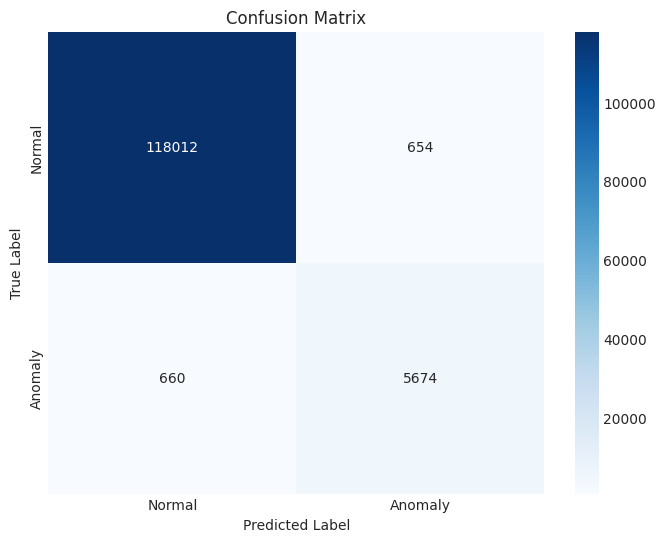

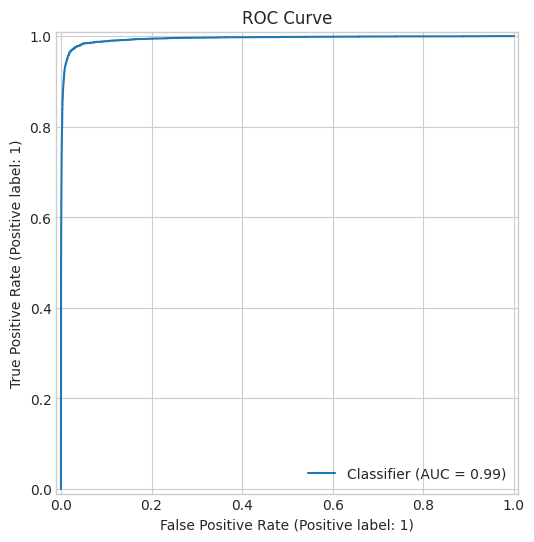

In [35]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
# Note: We can't use from_estimator directly as it expects a classifier interface.
# We build it manually using the true labels and anomaly scores.
RocCurveDisplay.from_predictions(y_test, y_scores, ax=ax)
ax.set_title('ROC Curve')
plt.show()

**Interpretation**: The model shows a very high recall for the anomaly class, meaning it is excellent at catching actual anomalies. The high AUC score also indicates it's very good at distinguishing between normal and anomalous transactions.

--- 
## Step 6: Saving the Model & Supporting Artifacts

To use this model in production, we need to save three things:
1.  The trained **model** itself.
2.  The `StandardScaler` **object** (to process new data exactly the same way).
3.  The **user average features** DataFrame (to calculate deviation for new transactions).

In [36]:
# Save the model
joblib.dump(model, 'anomaly_detection_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the user average features
# In a real system, this would be a table in your Postgres DB, updated periodically.
user_avg_features.to_csv('user_average_features.csv', index=False)

print("Model, scaler, and user features have been saved successfully.")

Model, scaler, and user features have been saved successfully.


--- 
## Step 7: The Pathway for Real-Time Integration

Here's how to connect this trained model to your real-time banking application using a deployment **pathway**.

#### **On-Demand Prediction Flow:**

1.  **API Endpoint**: Your banking application backend (e.g., written in Python with Flask/FastAPI) receives a new transaction request: `{ "userId": "user_123", "amount": 75000.00, "latitude": 13.0, "longitude": 77.5 }`.

2.  **Load Artifacts**: The API loads the saved `anomaly_detection_model.pkl`, `scaler.pkl`, and the `user_average_features.csv` data (or fetches it from the Postgres DB).

3.  **Real-Time Feature Engineering**: 
    - It retrieves the specific user's historical averages (`user_avg_amount`, `user_avg_lat`, `user_avg_lon`) from the loaded data.
    - It calculates the `amount_deviation` and `distance_from_home` for the new transaction, just as we did in training.
    - It gets the `hour_of_day` and `day_of_week` from the current timestamp.

4.  **Preprocess Input**: It uses the loaded `scaler.transform()` to scale the newly created feature vector.

5.  **Predict**: The scaled vector is passed to `model.predict()`. The model returns `-1` for an anomaly and `1` for a normal transaction.

6.  **Take Action**: 
    - If the model's prediction is **`-1`**, the system flags the transaction as an anomaly.
    - The banking application can then trigger a secondary action: decline the transaction, send a push notification for manual verification, or require 2FA.

This entire sequence forms a robust **pathway** from a live transaction event to an intelligent, real-time decision.